In [1]:
import os
from openai import AzureOpenAI
from dotenv import load_dotenv, find_dotenv

load_dotenv()

aoai_api_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
aoai_api_key = os.getenv("AZURE_OPENAI_API_KEY")
aoai_api_version = os.getenv("AZURE_OPENAI_API_VERSION")
aoai_deployment_name = os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME")

if not aoai_api_version:
    aoai_api_version = os.getenv("OPENAI_API_VERSION")
if not aoai_deployment_name:
    aoai_deployment_name = os.getenv("DEPLOYMENT_NAME")

try:
    print("=== Initialized AzuureOpenAI client ===")
    print(f"AZURE_OPENAI_ENDPOINT={aoai_api_endpoint}")
    print(f"AZURE_OPENAI_API_VERSION={aoai_api_version}")
    print(f"AZURE_OPENAI_DEPLOYMENT_NAME={aoai_deployment_name}")
except (ValueError, TypeError) as e:
    print(e)

=== Initialized AzuureOpenAI client ===
AZURE_OPENAI_ENDPOINT=https://aihubeastus-aiservices.openai.azure.com/
AZURE_OPENAI_API_VERSION=2025-01-01-preview
AZURE_OPENAI_DEPLOYMENT_NAME=gpt-4o


In [2]:
from azure_genai_utils.rag.pdf import PDFRetrievalChain

pdf_path = "./AutoGen-paper.pdf"

pdf = PDFRetrievalChain(
    source_uri=[pdf_path],
    loader_type="PDFPlumber",
    model_name="gpt-4o-mini",
    embedding_name="text-embedding-3-large",
    chunk_size=500,
    chunk_overlap=50,
).create_chain()

pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

/Users/daekeun/.pyenv/versions/3.12.2/envs/py312-dev/lib/python3.12/site-packages/langsmith/client.py:354: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [3]:
# from langchain import hub
# from langchain_core.output_parsers import StrOutputParser
# from langchain_core.prompts import load_prompt
# from langchain_openai import AzureChatOpenAI


# def format_docs(docs):
#     return "\n\n".join(
#         [
#             f'<document><content>{doc.page_content}</content><source>{doc.metadata["source"]}</source><page>{doc.metadata["page"]+1}</page></document>'
#             for doc in docs
#         ]
#     )

In [4]:
import json
from typing import List, Literal, Optional

import tiktoken
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.documents import Document
from langchain_core.embeddings import Embeddings
from langchain_core.messages import get_buffer_string
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import AzureChatOpenAI
from langchain_openai.embeddings import AzureOpenAIEmbeddings
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode

In [5]:
embeddings = AzureOpenAIEmbeddings(
    model="text-embedding-3-large",
    chunk_size=1000,
)
recall_vector_store = InMemoryVectorStore(embeddings)

### Define tools

In [6]:
import uuid


def get_user_id(config: RunnableConfig) -> str:
    user_id = config["configurable"].get("user_id")
    if user_id is None:
        raise ValueError("User ID needs to be provided to save a memory.")

    return user_id


@tool
def save_recall_memory(memory: str, config: RunnableConfig) -> str:
    """Save memory to vectorstore for later semantic retrieval."""
    user_id = get_user_id(config)
    document = Document(
        page_content=memory, id=str(uuid.uuid4()), metadata={"user_id": user_id}
    )
    recall_vector_store.add_documents([document])
    return memory


@tool
def search_recall_memories(query: str, config: RunnableConfig) -> List[str]:
    """Search for relevant memories."""
    user_id = get_user_id(config)

    def _filter_function(doc: Document) -> bool:
        return doc.metadata.get("user_id") == user_id

    documents = recall_vector_store.similarity_search(
        query, k=3, filter=_filter_function
    )
    return [document.page_content for document in documents]


@tool
def pdf_retrieve(query: str, config: RunnableConfig):
    """Retrieve information regarding AutoGen paper. If the query asks for details about AutoGen, use this tool."""
    print("\n==== [RETRIEVE] ====\n")
    # msg = state["messages"][-1]["user"]
    # convo_str = get_buffer_string(state["messages"])
    documents = pdf_retriever.invoke(query)
    return [document.page_content for document in documents]

In [7]:
from azure_genai_utils.tools import BingSearch

WEB_SEARCH_FORMAT_OUTPUT = False

web_search_tool = BingSearch(
    max_results=1,
    locale="en-US",
    include_news=False,
    include_entity=False,
    format_output=WEB_SEARCH_FORMAT_OUTPUT,
)

In [ ]:
# search = TavilySearchResults(max_results=1)
tools = [save_recall_memory, search_recall_memories, pdf_retrieve, web_search_tool]

In [9]:
from typing import List
from typing_extensions import TypedDict, Annotated


class State(MessagesState):
    # add memories that will be retrieved based on the conversation context
    recall_memories: Annotated[List[str], "List of recall memories"]
    # documents: Annotated[List[str], "List of documents"]

In [10]:
system_prpmpt = """
You are a helpful assistant with advanced long-term memory capabilities. 
Powered by a stateless LLM, you must rely on external memory to store information between conversations. 
Utilize the available memory tools to store and retrieve important details that will help you better attend to the user's needs and understand their context.

## Memory Usage Guidelines:
1. Actively use memory tools (save_core_memory, save_recall_memory) to build a comprehensive understanding of the user.
2. Make informed suppositions and extrapolations based on stored memories.
3. Regularly reflect on past interactions to identify patterns and preferences.
4. Update your mental model of the user with each new piece of information.
5. Cross-reference new information with existing memories for consistency.
6. Prioritize storing emotional context and personal values alongside facts.
7. Use memory to anticipate needs and tailor responses to the user's style.
8. Recognize and acknowledge changes in the user's situation or perspectives over time.
9. Leverage memories to provide personalized examples and analogies.
10. Recall past challenges or successes to inform current problem-solving.

## Constraint
1. Review the provided context thoroughly and extract key details related to the question.
2. Craft a precise answer based on the relevant information.
3. Keep the answer concise but logical/natural/in-depth.
4. If the retrieved context does not contain relevant information or no context is available, respond with: 'I can't find the answer to that question in the context.'

## Recall Memories
Recall memories are contextually retrieved based on the current conversation:
{recall_memories}

## Instructions
Engage with the user naturally, as a trusted colleague or friend. There's no need to explicitly mention your memory capabilities. 
Instead, seamlessly incorporate your understanding of the user into your responses. 
Be attentive to subtle cues and underlying emotions. Adapt your communication style to match the user's preferences and current emotional state. 
Use tools to persist information you want to retain in the next conversation. 
If you do call tools, all text preceding the tool call is an internal message. 
Respond AFTER calling the tool, once you have confirmation that the tool completed successfully.
"""

# Define the prompt template for the agent
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prpmpt),
        ("placeholder", "{messages}"),
    ]
)

In [ ]:
# # 예쁘게 출력
# print(prompt.pretty_print())

In [11]:
model = AzureChatOpenAI(model_name=aoai_deployment_name)
model_with_tools = model.bind_tools(tools)
tokenizer = tiktoken.encoding_for_model("gpt-4o")

# def retrieve(state: State) -> State:
#     """
#     Retrieve documents based on the user question.
#     """
#     print("\n==== [RETRIEVE] ====\n")
#     # msg = state["messages"][-1]["user"]
#     convo_str = get_buffer_string(state["messages"])
#     documents = pdf_retriever.invoke(convo_str)
#     return {"documents": documents}

from typing import List
from typing_extensions import TypedDict, Annotated


class State(MessagesState):
    # add memories that will be retrieved based on the conversation context
    recall_memories: Annotated[List[str], "List of recall memories"]


def agent(state: State) -> State:
    """Process the current state and generate a response using the LLM.

    Args:
        state (schemas.State): The current state of the conversation.

    Returns:
        schemas.State: The updated state with the agent's response.
    """
    bound = prompt | model_with_tools
    recall_str = (
        "<recall_memory>\n" + "\n".join(state["recall_memories"]) + "\n</recall_memory>"
    )
    prediction = bound.invoke(
        {
            "messages": state["messages"],
            # "context": format_docs(state["documents"]),
            "recall_memories": recall_str,
        }
    )
    return {
        "messages": [prediction],
    }


def load_memories(state: State, config: RunnableConfig) -> State:
    """Load memories for the current conversation.

    Args:
        state (schemas.State): The current state of the conversation.
        config (RunnableConfig): The runtime configuration for the agent.

    Returns:
        State: The updated state with loaded memories.
    """
    convo_str = get_buffer_string(state["messages"])
    convo_str = tokenizer.decode(tokenizer.encode(convo_str)[:2048])
    recall_memories = search_recall_memories.invoke(convo_str, config)
    return {
        "recall_memories": recall_memories,
    }


def route_tools(state: State):
    """Determine whether to use tools or end the conversation based on the last message.

    Args:
        state (schemas.State): The current state of the conversation.

    Returns:
        Literal["tools", "__end__"]: The next step in the graph.
    """
    msg = state["messages"][-1]
    if msg.tool_calls:
        return "tools"

    return END

In [12]:
# Create the graph and add nodes
builder = StateGraph(State)

builder.add_node(load_memories)
builder.add_node(agent)
builder.add_node("tools", ToolNode(tools))

# Add edges to the graph
builder.add_edge(START, "load_memories")
builder.add_edge("load_memories", "agent")
builder.add_conditional_edges("agent", route_tools, ["tools", END])
builder.add_edge("tools", "agent")

# Compile the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [ ]:
# from IPython.display import Image, display

# display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
def pretty_print_stream_chunk(chunk):
    for node, updates in chunk.items():
        print(f"Update from node: {node}")
        if "messages" in updates:
            updates["messages"][-1].pretty_print()
        else:
            print(updates)

        print("\n")

In [14]:
# NOTE: we're specifying `user_id` to save memories for a given user
config = {"configurable": {"user_id": "1", "thread_id": "1"}}

for chunk in graph.stream(
    {"messages": [("user", "Daekeun is a Machine Learning geek. He loves to learn AIML new things.")]},
    config=config,
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': []}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_recall_memory (call_RnPKSwbwnR33G3BikwwUNFVH)
 Call ID: call_RnPKSwbwnR33G3BikwwUNFVH
  Args:
    memory: Daekeun is passionate about Machine Learning and enjoys learning new concepts related to AI and ML.


Update from node: tools
================================= Tool Message =================================
Name: save_recall_memory

Daekeun is passionate about Machine Learning and enjoys learning new concepts related to AI and ML.


Update from node: agent
================================== Ai Message ==================================

Got it! If you want to delve into any specific AI or Machine Learning topics, let me know!




In [15]:
for chunk in graph.stream(
    {"messages": [("user", "Daekeun provides AIML technology support at Microsoft.")]},
    config=config,
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ['Daekeun is passionate about Machine Learning and enjoys learning new concepts related to AI and ML.']}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_recall_memory (call_lGAVrh9UHJ7TckqOngfBOHjY)
 Call ID: call_lGAVrh9UHJ7TckqOngfBOHjY
  Args:
    memory: Daekeun provides AI and Machine Learning technology support at Microsoft.


Update from node: tools
================================= Tool Message =================================
Name: save_recall_memory

Daekeun provides AI and Machine Learning technology support at Microsoft.


Update from node: agent
================================== Ai Message ==================================

That's impressive! Let me know if there's any way I can assist with your work or learning endeavors in AIML.




In [16]:
for chunk in graph.stream(
    {"messages": [("user", "Daekeun wants to know AutoGen")]}, config=config
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ['Daekeun provides AI and Machine Learning technology support at Microsoft.', 'Daekeun is passionate about Machine Learning and enjoys learning new concepts related to AI and ML.']}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  pdf_retrieve (call_xtbWZ0mupRSllAjkj7RTWLrR)
 Call ID: call_xtbWZ0mupRSllAjkj7RTWLrR
  Args:
    query: AutoGen



==== [RETRIEVE] ====

Update from node: tools
================================= Tool Message =================================
Name: pdf_retrieve

["tasks. AutoGen agents are customizable, conversable, and can operate in vari-\nous modes that employ combinations of LLMs, human inputs, and tools. Using\nAutoGen, developers can also flexibly define agent interaction behaviors. Both\nnaturallanguageandcomputercodecanbeusedtoprogramflexibleconversation\npatterns for different applications. AutoGen serves as a generic framework f

In [17]:
for chunk in graph.stream(
    {"messages": [("user", "What is AutoGen's main featrues?")]}, config=config
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ['Daekeun provides AI and Machine Learning technology support at Microsoft.', 'Daekeun is passionate about Machine Learning and enjoys learning new concepts related to AI and ML.']}


Update from node: agent
================================== Ai Message ==================================

AutoGen’s main features include:

1. **Customizable and Conversable Agents**: 
   - AutoGen agents are designed to be adaptable, capable of leveraging large language models (LLMs), human inputs, tool integrations, or a combination of these.

2. **Dynamic and Flexible Conversation Patterns**: 
   - AutoGen supports both static and dynamic conversation flows, allowing agents to converse and adjust based on different application needs.

3. **Agent Interaction Behavior**:
   - Developers can define flexible and programmable conversation workflows, including customized reply functions and behavioral patterns.

4. **Tool Integration and Execution**:
   - A

In [ ]:
for chunk in graph.stream(
    {
        "messages": [
            ("user", "Daekeun wants to study AutoGen in 4 weeks. How can he does?")
        ]
    },
    config=config,
):
    pretty_print_stream_chunk(chunk)

In [ ]:
config = {"configurable": {"user_id": "1", "thread_id": "1"}}

In [18]:
for chunk in graph.stream(
    {
        "messages": [
            ("user", "Daekeun wants to study AutoGen in 2 weeks. Please recommend Microsoft's website or appropriate learning material.")
        ]
    },
    config=config,
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ['Daekeun provides AI and Machine Learning technology support at Microsoft.', 'Daekeun is passionate about Machine Learning and enjoys learning new concepts related to AI and ML.']}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  bing_search_results (call_ZylvsVW2yFx8TeL13HUNBUrz)
 Call ID: call_ZylvsVW2yFx8TeL13HUNBUrz
  Args:
    query: Microsoft learning material AutoGen study


Update from node: tools
================================= Tool Message =================================
Name: bing_search_results

[{"kind": "web", "title": "AutoGen: Publications - Microsoft Research", "snippet": "<b>AutoGen</b>: Enabling Next-Gen LLM Applications via Multi-Agent Conversation Qingyun Wu, Gagan Bansal, Jieyu Zhang, Yiran Wu, Beibin Li, Erkang (Eric) Zhu, Li Jiang, Xiaoyun Zhang, Shaokun Zhang, Ahmed Awadallah, Ryen W. White, Doug Burger, Chi Wang COLM 2024 | August 20

In [ ]:
d

Now we can use the saved information about our user on a different thread. Let's try it out:

In [19]:
config = {"configurable": {"user_id": "2", "thread_id": "1"}}

for chunk in graph.stream(
    {"messages": [("user", "Hyo is a big fan of Microsoft")]}, config=config
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': []}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_recall_memory (call_msnnVuceYB8ysbCUtZsoC5mE)
 Call ID: call_msnnVuceYB8ysbCUtZsoC5mE
  Args:
    memory: Hyo is a big fan of Microsoft.


Update from node: tools
================================= Tool Message =================================
Name: save_recall_memory

Hyo is a big fan of Microsoft.


Update from node: agent
================================== Ai Message ==================================

That's awesome! If Hyo is curious about anything related to Microsoft—like its products, services, or innovations—I'd be happy to help or share some insights.




In [20]:
config = {"configurable": {"user_id": "2", "thread_id": "1"}}

for chunk in graph.stream(
    {"messages": [("user", "Hyo is interested in AutoGen and Semantic Kernel")]}, config=config
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ['Hyo is a big fan of Microsoft.']}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_recall_memory (call_XrTkFbnbEkcPj6JFGBs4x5CJ)
 Call ID: call_XrTkFbnbEkcPj6JFGBs4x5CJ
  Args:
    memory: Hyo is interested in AutoGen and Semantic Kernel.


Update from node: tools
================================= Tool Message =================================
Name: save_recall_memory

Hyo is interested in AutoGen and Semantic Kernel.


Update from node: agent
================================== Ai Message ==================================

That's great! If Hyo needs resources, explanations, or guidance on AutoGen or Semantic Kernel, I can provide helpful information or recommendations. Just let me know!




In [21]:
config = {"configurable": {"user_id": "2", "thread_id": "1"}}

for chunk in graph.stream(
    {"messages": [("user", "Where is learning materials?")]}, config=config
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ['Hyo is interested in AutoGen and Semantic Kernel.', 'Hyo is a big fan of Microsoft.']}


Update from node: agent
================================== Ai Message ==================================

For AutoGen, you can find detailed learning materials, publications, and insights on Microsoft's official page [here](https://www.microsoft.com/en-us/research/project/autogen/publications/).

For Semantic Kernel, its primary learning resources are on its [GitHub repository](https://github.com/microsoft/semantic-kernel), where you'll find documentation, examples, and implementation guidelines to study and experiment with the framework.

Let me know if you'd like further assistance navigating or understanding these materials!




Notice how the agent is loading the most relevant memories before answering, and in our case suggests the dinner recommendations based on both the food preferences as well as location.

Finally, let's use the search tool together with the rest of the conversation context and memory to find location of a pizzeria:

에이전트가 답변하기 전에 가장 관련성 높은 기억을 불러오는 방식에 주목하세요. 이 경우에는 음식 선호도와 위치를 모두 고려하여 저녁 식사 추천을 제안합니다.

마지막으로, 검색 도구를 나머지 대화 맥락 및 기억과 함께 사용하여 피자 가게의 위치를 ​​찾아 보겠습니다.

In [ ]:
for chunk in graph.stream(
    {"messages": [("user", "what's the address for joe's in greenwich village?")]},
    config=config,
):
    pretty_print_stream_chunk(chunk)

### Adding structured memories

지금까지 메모리를 문자열로 표현했습니다(예: "John은 피자를 좋아해"). 이는 메모리를 벡터 저장소에 저장할 때 자연스러운 표현입니다. 그래프 데이터베이스와 같은 다른 지속성 백엔드를 사용하는 것이 유용하다면, 애플리케이션을 업데이트하여 추가적인 구조를 가진 메모리를 생성할 수 있습니다.

아래에서는 save_recall_memory 도구를 업데이트하여 지식 그래프에 저장하기에 적합한 "지식 트리플", 즉 주어, 술어, 목적어를 가진 3-튜플 목록을 받습니다. 그러면 모델이 도구 호출의 일부로 이러한 표현을 생성합니다.

간단성을 위해 이전과 동일한 벡터 데이터베이스를 사용하지만, save_recall_memory 및 search_recall_memory 도구를 추가로 업데이트하여 그래프 데이터베이스와 상호 작용할 수 있습니다. 지금은 save_recall_memory 도구만 업데이트하면 됩니다.

In [ ]:
recall_vector_store = InMemoryVectorStore(embeddings)

In [22]:
from typing_extensions import TypedDict


class KnowledgeTriple(TypedDict):
    subject: str
    predicate: str
    object_: str

# @tool
# def save_recall_memory(memory: str, config: RunnableConfig) -> str:
#     """Save memory to vectorstore for later semantic retrieval."""
#     user_id = get_user_id(config)
#     document = Document(
#         page_content=memory, id=str(uuid.uuid4()), metadata={"user_id": user_id}
#     )
#     recall_vector_store.add_documents([document])
#     return memory


@tool
def save_recall_memory(memories: List[KnowledgeTriple], config: RunnableConfig) -> str:
    """Save memory to vectorstore for later semantic retrieval."""
    user_id = get_user_id(config)
    for memory in memories:
        serialized = " ".join(memory.values())
        document = Document(
            serialized,
            id=str(uuid.uuid4()),
            metadata={
                "user_id": user_id,
                **memory,
            },
        )
        recall_vector_store.add_documents([document])
    return memories

In [23]:
tools = [save_recall_memory, search_recall_memories, pdf_retrieve, web_search_tool]
model_with_tools = model.bind_tools(tools)

# Create the graph and add nodes
builder = StateGraph(State)
builder.add_node(load_memories)
builder.add_node(agent)
builder.add_node("tools", ToolNode(tools))

# Add edges to the graph
builder.add_edge(START, "load_memories")
builder.add_edge("load_memories", "agent")
builder.add_conditional_edges("agent", route_tools, ["tools", END])
builder.add_edge("tools", "agent")

# Compile the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [24]:
config = {"configurable": {"user_id": "3", "thread_id": "1"}}

for chunk in graph.stream({"messages": [("user", "Hi I am Wonchan.")]}, config=config):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': []}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_recall_memory (call_zDJ5n3jwkQWHtFKTz3WOAY1n)
 Call ID: call_zDJ5n3jwkQWHtFKTz3WOAY1n
  Args:
    memories: [{'subject': 'Wonchan', 'predicate': 'introduced themselves', 'object_': 'Hi, I am Wonchan.'}]


Update from node: tools
================================= Tool Message =================================
Name: save_recall_memory

[{"subject": "Wonchan", "predicate": "introduced themselves", "object_": "Hi, I am Wonchan."}]


Update from node: agent
================================== Ai Message ==================================

Hello, Wonchan! How can I assist you today?




In [25]:
for chunk in graph.stream(
    {"messages": [("user", "I am non-tech, but interested in Microsoft's multi-agent strategy and tech stack like AutoGen.")]}, config=config
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ['Wonchan introduced themselves Hi, I am Wonchan.']}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_recall_memory (call_KAafUGDKnzp5QtEmr1i91Ghg)
 Call ID: call_KAafUGDKnzp5QtEmr1i91Ghg
  Args:
    memories: [{'subject': 'Wonchan', 'predicate': 'is non-tech but interested', 'object_': "Microsoft's multi-agent strategy and tech stack like AutoGen."}]


Update from node: tools
================================= Tool Message =================================
Name: save_recall_memory

[{"subject": "Wonchan", "predicate": "is non-tech but interested", "object_": "Microsoft's multi-agent strategy and tech stack like AutoGen."}]


Update from node: agent
================================== Ai Message ==================================

That's great, Wonchan! Microsoft's multi-agent strategy and their AutoGen tech stack involve innovative technologies focused on enab

As before, the memories generated from one thread are accessed in another thread from the same user:

In [30]:
config = {"configurable": {"user_id": "3", "thread_id": "2"}}

for chunk in graph.stream(
    {"messages": [("user", "Recommend me a website where I can easily try AutoGen hands-on")]}, config=config
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ["Wonchan is non-tech but interested Microsoft's multi-agent strategy and tech stack like AutoGen.", 'Wonchan introduced themselves Hi, I am Wonchan.']}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  bing_search_results (call_YTjtERjiXOdsq0XcFKjzMpM8)
 Call ID: call_YTjtERjiXOdsq0XcFKjzMpM8
  Args:
    query: AutoGen open-source framework hands-on website


Update from node: tools
================================= Tool Message =================================
Name: bing_search_results

[{"kind": "web", "title": "AutoGen Studio — AutoGen", "snippet": "Caution <b>AutoGen</b> Studio is meant to help you rapidly prototype multi-agent workflows and demonstrate an example of end user interfaces built with <b>AutoGen</b>. It is not meant to be a production-ready app. Developers are encouraged to use the <b>AutoGen</b> <b>framework</b> to build their own applications, 

In [39]:
config = {"configurable": {"user_id": "3", "thread_id": "2"}}

for chunk in graph.stream(
    {"messages": [("user", "Recommend other multi-agent frameworks to me inorder to learn about other companies' multi-agent strategies")]}, config=config
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ["Wonchan is non-tech but interested Microsoft's multi-agent strategy and tech stack like AutoGen.", 'Wonchan introduced themselves Hi, I am Wonchan.']}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  bing_search_results (call_pYjDSRklOEKy34SREElGGmwX)
 Call ID: call_pYjDSRklOEKy34SREElGGmwX
  Args:
    query: current popular multi-agent frameworks from companies


Update from node: tools
================================= Tool Message =================================
Name: bing_search_results

[{"kind": "web", "title": "Multi-Agent AI Systems: Frameworks, Use Cases &amp; Trends 2025", "snippet": "Why <b>Multi-Agent</b> Systems Matter in 2025? The rise of <b>multi-agent</b> AI systems is becoming increasingly important in 2025, driven by the growing complexity of enterprise infrastructures, global markets, and the demand for real-time decision-making. Traditional

In [45]:
records = recall_vector_store.similarity_search(
    "multi-agent", k=3, filter=lambda doc: doc.metadata["user_id"] == "3"
)
print(records)

[Document(id='3f669daa-6568-494d-a67f-ab5859268c2d', metadata={'user_id': '3', 'subject': 'Wonchan', 'predicate': 'is non-tech but interested', 'object_': "Microsoft's multi-agent strategy and tech stack like AutoGen."}, page_content="Wonchan is non-tech but interested Microsoft's multi-agent strategy and tech stack like AutoGen."), Document(id='649391d9-e34f-42d2-8239-d68637c5f666', metadata={'user_id': '3', 'subject': 'Wonchan', 'predicate': 'introduced themselves', 'object_': 'Hi, I am Wonchan.'}, page_content='Wonchan introduced themselves Hi, I am Wonchan.')]


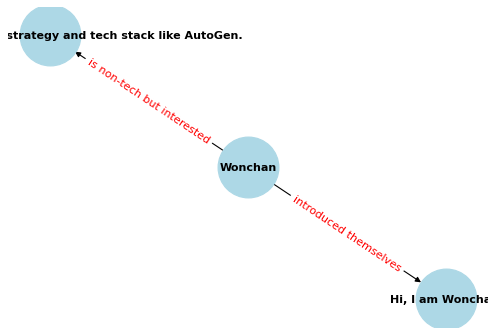

In [46]:
import matplotlib.pyplot as plt
import networkx as nx

# Fetch records
records = recall_vector_store.similarity_search(
    "multi-agent", k=3, filter=lambda doc: doc.metadata["user_id"] == "3"
)


# Plot graph
plt.figure(figsize=(6, 4), dpi=80)
G = nx.DiGraph()

for record in records:
    G.add_edge(
        record.metadata["subject"],
        record.metadata["object_"],
        label=record.metadata["predicate"],
    )

pos = nx.spring_layout(G)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=3000,
    node_color="lightblue",
    font_size=10,
    font_weight="bold",
    arrows=True,
)
edge_labels = nx.get_edge_attributes(G, "label")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")
plt.show()